In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from os.path import join
import pickle
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from correlate import zero_lag_correlate
from filtering import freq_filt
from tqdm import tqdm

In [2]:
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [3]:
banner_coords = (44.3, -115.233)
url = f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2021-12-01&endtime=2022-06-15&latitude={banner_coords[0]}&longitude={banner_coords[1]}&maxradiuskm=30'
df = pd.read_csv(url)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 'EPSG:4326')
res = gdf.loc[:, ['time', 'geometry', 'depth', 'mag', 'id']]

In [ ]:
# ax = res.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', markersize = res.mag*15, legend = True)
f, ax = plt.subplots(figsize=(16, 10))
sc = ax.scatter(x = res.geometry.x, y = res.geometry.y, s=res.mag)

ax.scatter(x = banner_coords[1], y = banner_coords[0], s = 30, color = 'red', marker = 'x')
cx.add_basemap(ax, crs = gdf.crs, source = cx.providers.OpenTopoMap)
plt.legend(*sc.legend_elements("sizes", num=6))
plt.show()

In [4]:
# Calculate Distance to Snotel from Source
wgs84 = pyproj.CRS('EPSG:4326')
itm = pyproj.CRS('EPSG:8826') # Idaho Tranvserse Mercator - https://epsg.io/8826
project = pyproj.Transformer.from_crs(wgs84, itm, always_xy=True).transform
wgs_snotel = Point(*banner_coords[::-1])
itm_snotel = transform(project, wgs_snotel)
res_geo = res.to_crs('EPSG:8826')
res.loc[:, 'distance_km'] = res_geo.distance(itm_snotel)/1000 # convert m to km
# Calculate Azimuth
geodesic = pyproj.Geod(ellps='WGS84')
for i,r in res.iterrows():
    fwd_azimuth,_,_ = geodesic.inv(wgs_snotel.x, wgs_snotel.y, r.geometry.x, r.geometry.y)
    res.loc[i, 'azimuth'] = fwd_azimuth

In [7]:
for i, r in tqdm(res.iterrows(), total = len(res)):
    if r.mag>2.5:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        if dt in days.keys():
            day = days[dt]
            if 0.33 in day.keys():
                s = pd.to_datetime(r.time)
                ps = s - pd.Timedelta('20 seconds') 
                e = s + pd.Timedelta('20 seconds')
                d = {}
                d['lower'] = pd.read_parquet(day[0.33])
                d['upper'] = pd.read_parquet(day[1])
                try:
                    pre = freq_filt(d['lower'].loc[ps:s, :].values.ravel(), fc = 1, kind = 'highpass', sps = sps)
                    pre_mean = np.nanmean(pre)
                    pre_quant95 = np.nanquantile(pre, 0.95)
                    for k in d.keys():
                        d[k] = d[k].loc[s:e, :].values.ravel()
                        d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
                    corr = zero_lag_correlate(d['lower'], d['upper'], 2)[:-10]
                    res.loc[i, 'max_corr'] = np.nanmax(corr)
                    res.loc[i, 'mean_corr'] = np.nanmean(corr)
                    res.loc[i, 'corr_95'] = np.nanquantile(corr, 0.95)
                    res.loc[i, 'max_ratio'] = np.abs(np.nanmax(d['lower'])/pre_mean)
                    res.loc[i, 'eq_mean'] = np.nanmean(d['lower'])
                    res.loc[i, 'eq_quant95'] = np.nanquantile(d['lower'], 0.95)
                    res.loc[i, 'quant_ratio'] = np.abs(np.nanquantile(d['lower'], 0.95)/pre_quant95)
                    res.loc[i, 'mean_ratio'] = np.abs( np.nanmean(d['lower'])/pre_mean)
                    res.loc[i, 'max_mean_eq_ratio'] =  np.nanmax(d['lower'])/ np.nanmean(d['lower'])
                except ValueError:
                    pass

  0%|          | 0/469 [00:00<?, ?it/s]/bsuhome/zacharykeskinen/infrasound/src/functions/correlate.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.einsum('i,i->',A_mA,B_mB)/np.sqrt(ssA*ssB)
100%|██████████| 469/469 [02:02<00:00,  3.84it/s]


0.8501263157565713
Quant ratio: 1.8400236703867474
pre mean = 4.685969076421128e-06. eq mean = 3.066516566070059e-05
max ratio: 14202.751365274895. mean ratio: 6.5440392714074145
M2.7 at 6.266593145838126 km away at depth = 10.0 km


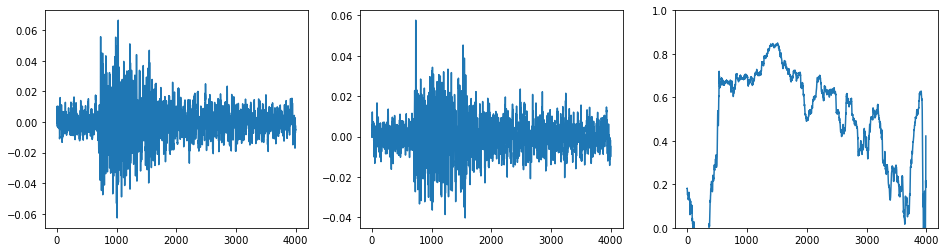

0.8284898739958878
Quant ratio: 1.4948485017158535
pre mean = 2.007500115266728e-06. eq mean = 2.731229130451516e-05
max ratio: 17428.042916194936. mean ratio: 13.605125646972274
M3.1 at 21.995723731039575 km away at depth = 10.0 km


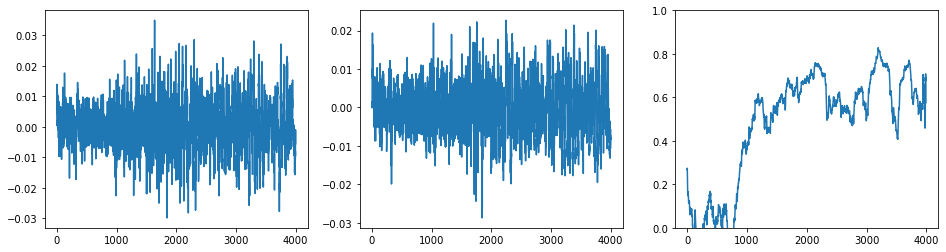

0.7508629062261991
Quant ratio: 1.36171588243808
pre mean = -7.418276463428957e-06. eq mean = 2.382630380789588e-05
max ratio: 5088.400422256949. mean ratio: 3.2118382113899573
M2.9 at 14.817744626600257 km away at depth = 10.0 km


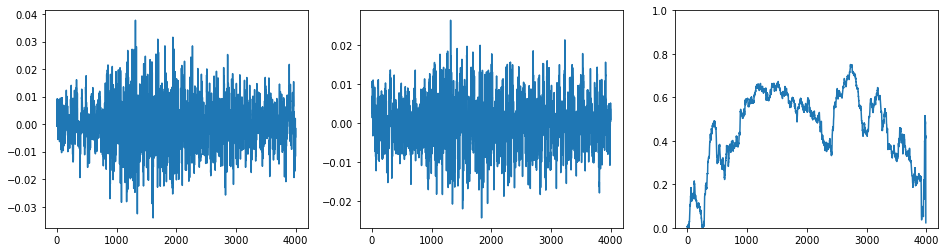

0.80597136867833
Quant ratio: 1.985071286454794
pre mean = 6.094240071023615e-06. eq mean = 2.5384718614470413e-05
max ratio: 22798.35035866785. mean ratio: 4.165362427247913
M2.6 at 7.493613690593093 km away at depth = 10.0 km


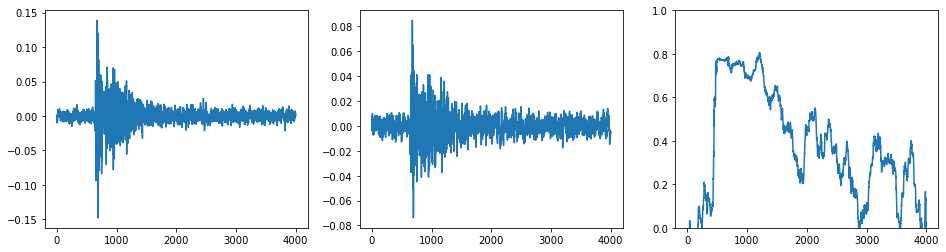

0.8666221373329872
Quant ratio: 2.497507798416614
pre mean = 6.771120320885628e-06. eq mean = -3.209079237432255e-05
max ratio: 18335.754301001467. mean ratio: 4.739362299520508
M2.9 at 8.322661860264192 km away at depth = 10.0 km


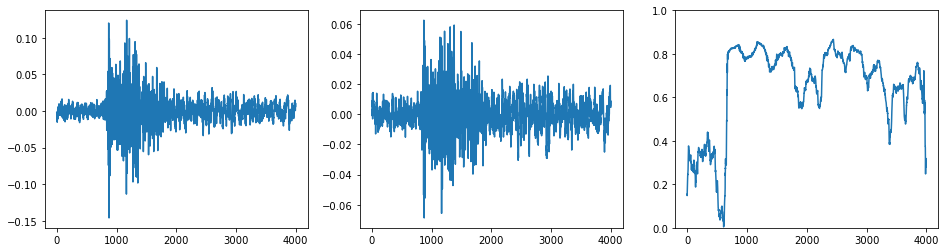

In [11]:
j = 0
for i, r in res.iterrows():
    if j < 5:
        if r.mag > 2.5:
            dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
            if dt in days.keys():
                day = days[dt]
                if 0.33 in day.keys():
                    s = pd.to_datetime(r.time)
                    ps = s - pd.Timedelta('20 seconds') 
                    e = s + pd.Timedelta('20 seconds')
                    d = {}
                    d['lower'] = pd.read_parquet(day[0.33])
                    d['upper'] = pd.read_parquet(day[1])
                    try:
                        pre = freq_filt(d['lower'].loc[ps:s, :].values.ravel(), fc = 1, kind = 'highpass', sps = sps)
                        pre_mean = np.nanmean(pre)
                        pre_quant95 = np.nanquantile(pre, 0.95)
                        for i, k in enumerate(d.keys()):
                            d[k] = d[k].loc[s:e, :].values.ravel()
                            d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
                        corr = zero_lag_correlate(d['lower'], d['upper'], 1)[:-10]
                        max_ratio = np.abs(np.nanmax(d['lower'])/pre_mean)
                        eq_mean = np.nanmean(d['lower'])
                        eq_quant95 = np.nanquantile(d['lower'], 0.95)
                        quant_ratio = np.abs(eq_quant95/pre_quant95)
                        mean_ratio = np.abs(eq_mean/pre_mean)
                        if np.nanmax(corr) >0.5 and quant_ratio > 1 and mean_ratio>1 and max_ratio > 2000:
                            print(np.nanmax(corr))
                            print(f'Quant ratio: {quant_ratio}')
                            print(f'pre mean = {pre_mean}. eq mean = {eq_mean}')
                            print(f'max ratio: {max_ratio}. mean ratio: {mean_ratio}')
                            f, axes = plt.subplots(1,3, figsize = (16,4))
                            print(f'M{r.mag} at {r.distance_km} km away at depth = {r.depth} km')
                            axes[0].plot(d['lower'])
                            axes[1].plot(d['upper'])
                            axes[2].plot(corr)
                            axes[2].set_ylim(0, 1.0)
                            plt.show()
                            j += 1
                    except ValueError:
                        pass